In [1]:
import os
import h5py
import numpy
import matplotlib.pyplot as plt
import cv2
import numpy as np
from datetime import datetime
import pandas as pd
import time
from scipy.signal import savgol_filter

In [8]:
def timestamp_to_numpy(timestamps):
    datetimes = [datetime.fromtimestamp(i) for i in timestamps]
    datetime_array = np.array(datetimes, dtype=np.datetime64)
    return(datetime_array)

def zscore(array):
    mean = array.mean()
    std = np.std(array)
    return((array-mean)/std)

def ms_from_start(datetimes):
    return(((datetimes-datetimes[0])/1000).astype(np.float64))

def get_mean_brightness(h5file, inds):
    lefts, rights = [], []
    for ind in inds:
        left = cv2.imdecode(h5file['left'][ind],0)
        right =  cv2.imdecode(h5file['right'][ind],0)
        lefts.append(left.mean())
        rights.append(right.mean())
    return(np.vstack((lefts, rights)).mean(axis=0))

def calculate_hist(array,binedges):
    binedges[0] = -np.inf
    binedges[-1] = np.inf
    histogram, bin_edges = np.histogram(array,binedges)
    bincenters = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
    return(histogram,bincenters)

def smooth(array, window_size=5):
    assert(window_size%2==1)
    filt = np.ones(window_size)/window_size
    # print(filt.sum())
    assert(abs(filt.sum()-1)<1e-6)
    
    return(np.convolve(array,filt, mode='same'))

In [2]:
datadir = r'/media/jim/FASTER/realsense/190325/JB040_191025_141007'
files = os.listdir(datadir)
files.sort()

[print(file) for file in files]
files = [os.path.join(datadir, file) for file in files]

JB040_2019-03-25_0001.h5
JB040_2019-03-25_0002.h5
left_ant.h5
left_post.h5
right_ant.h5
right_post.h5


In [4]:
master = files[5]
print(master)

/media/jim/FASTER/realsense/190325/JB040_191025_141007/right_post.h5


In [5]:
with h5py.File(master, 'r') as f:
    print(list(f.keys()))

['arrival_time', 'cputime', 'framecount', 'left', 'right', 'sestime', 'timestamp']


In [6]:
np.set_printoptions(suppress=True)

In [7]:
with h5py.File(master, 'r') as f:
    print('Arrival time: ', f['arrival_time'][0:4])
    print('cputime: ', f['cputime'][0:4])
    print('framecount: ', f['framecount'][0:4])
    print('sestime: ', f['sestime'][0:4])
    print('timestamp: ', f['timestamp'][0:4])

Arrival time:  [1.55353741e+09 1.55353741e+09 1.55353741e+09 1.55353741e+09]
cputime:  [1.55353741e+09 1.55353741e+09 1.55353741e+09 1.55353741e+09]
framecount:  [87 88 89 90]
sestime:  [0.00006361 0.01116905 0.0219015  0.03305907]
timestamp:  [1.55353741e+09 1.55353741e+09 1.55353741e+09 1.55353741e+09]


In [9]:
with h5py.File(master, 'r') as f:
    print('Arrival time:', timestamp_to_numpy(f['arrival_time'][0:1]))
    print('cputime:', timestamp_to_numpy(f['cputime'][0:1]))
    print('sestime:', f['sestime'][0:1])
    print('timestamp:', timestamp_to_numpy(f['timestamp'][0:1]))

Arrival time: ['2019-03-20T15:04:21.960000']
cputime: ['2019-03-20T15:04:21.951643']
sestime: [0.00005927]
timestamp: ['2019-03-20T15:04:21.960216']


In [10]:
t = range(0,1000)

with h5py.File(master, 'r') as f:
    arrival = timestamp_to_numpy(f['arrival_time'][t])
    cputime = timestamp_to_numpy(f['cputime'][t])
    sestime = f['sestime'][t]
    timestamp = timestamp_to_numpy(f['timestamp'][t])
    framecounts = f['framecount'][t]

In [12]:
plt.style.use('ggplot')

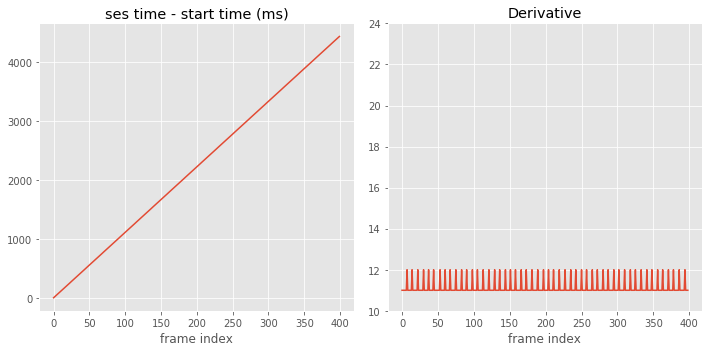

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
N=400
x = np.array(t[0:N])
y = ms_from_start(timestamp[0:N])
# y = sestime[0:N]*1000
ax[0].plot(x, y)
ax[1].plot(x[:-1], np.diff(y))

ax[0].set_xlabel('frame index')
ax[1].set_xlabel('frame index')
ax[0].set_title('ses time - start time (ms)')
ax[1].set_title('Derivative')
ax[1].set_ylim([10,24])
# ax.set_aspect('square')

plt.tight_layout()
plt.show()

/home/jim/anaconda3/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


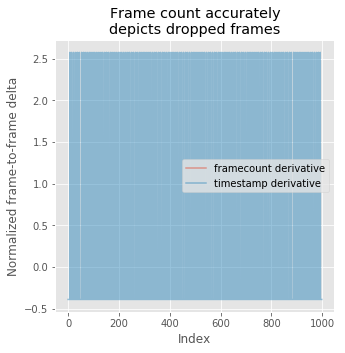

In [15]:
fig, ax= plt.subplots(1,1,figsize=(5,5))
y = zscore(np.diff(framecounts))
ax.plot(y, alpha=0.5)
y = zscore(np.diff(ms_from_start(timestamp)))
ax.plot(y, alpha=0.5)
ax.legend(['framecount derivative', 'timestamp derivative'])
ax.set_title('Frame count accurately\ndepicts dropped frames')
ax.set_xlabel('Index')
ax.set_ylabel('Normalized frame-to-frame delta')
plt.show()

In [16]:
with h5py.File(master, 'r') as f:
    framecounts = f['framecount'][:]
delta = np.diff(framecounts)
print(np.sum(delta>1.5)/delta.size)

0.0


In [17]:
for file in files:
    # hack to find camera files
    if not file.endswith('t.h5'):
        continue
    with h5py.File(file, 'r') as f:
        framecounts = f['framecount'][:]
        timestamps = ms_from_start(timestamp_to_numpy(f['timestamp'][:]))
    delta = np.diff(framecounts)
    dropped_frame_prop = np.sum(delta>1.5)/delta.size
    delta = np.diff(timestamps)
    dropped_frame_time = np.sum(delta>20)/delta.size
    print('%s: Frame count:%.04f Timestamp:%.04f' %(os.path.basename(file), 
                                                    dropped_frame_prop,
                                                   dropped_frame_time))

left_ant.h5: Frame count:0.0000 Timestamp:0.0003
left_post.h5: Frame count:0.0000 Timestamp:0.0001
right_ant.h5: Frame count:0.0000 Timestamp:0.0002
right_post.h5: Frame count:0.0000 Timestamp:0.0000


In [19]:
inds = range(10000)
with h5py.File(master, 'r') as h5file:
    brightness = get_mean_brightness(h5file, inds)

In [624]:
brightnesses = {}
frames = {}
timestamps = {}
sestimes = {}
for file in files:
    if not file.endswith('t.h5'):
        continue
    with h5py.File(file, 'r') as f:
        inds = range(0, len(f['left']))
        brightness = get_mean_brightness(f, inds)
        framecounts = f['framecount'][:]
        timestamp = timestamp_to_numpy(f['timestamp'][:])
        sestime = f['sestime'][:]
    key = os.path.basename(file)[:-3]
    brightnesses[key] = brightness
    frames[key] = framecounts
    timestamps[key] = timestamp
    sestimes[key]  = sestime
    
# correct a weird error
brightnesses['left_ant'][11661] = 0.169

In [ ]:
savgol_filter()

In [24]:
cams = ['left_ant', 'left_post', 'right_ant','right_post']

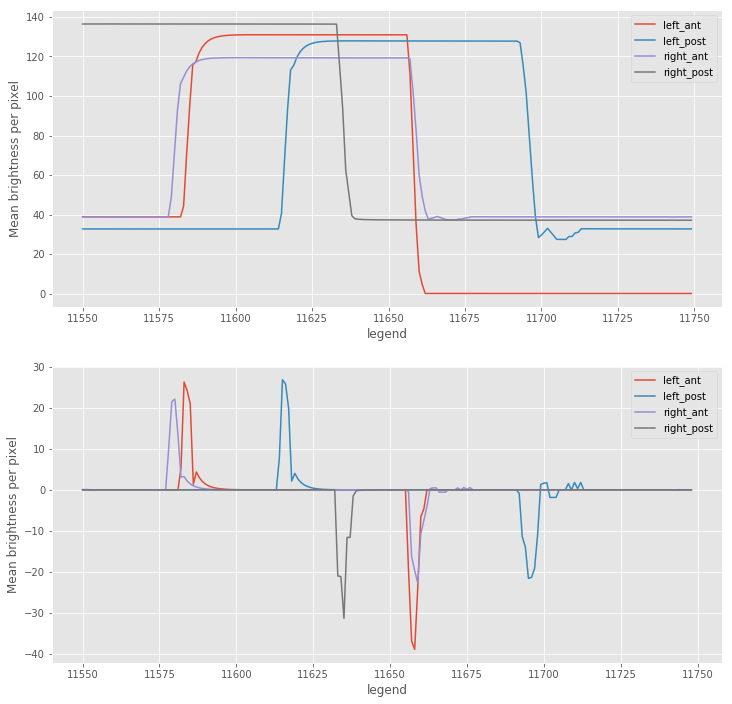

In [188]:
WINDOW_SIZE=3

fig, ax = plt.subplots(2,1, figsize=(12,12))
N = 200
# startind = np.random.randint(len(brightnesses['left_ant']-N))
startind = 11550
inds = range(startind,startind+N)

for cam in cams:
    array = savgol_filter(brightnesses[cam][inds],window_length=3,polyorder=1)
    # array = brightnesses[cam][inds]
    ax[0].plot(inds,array)
    ax[1].plot(inds[:-1],np.diff(array))

ax[0].legend(['left_ant', 'left_post', 'right_ant', 'right_post'])
ax[0].set_ylabel('Mean brightness per pixel')
ax[0].set_xlabel('legend')

ax[1].legend(['left_ant', 'left_post', 'right_ant', 'right_post'])
ax[1].set_ylabel('Mean brightness per pixel')
ax[1].set_xlabel('legend')
# ax[1].set_ylim([-50,50])

plt.show()

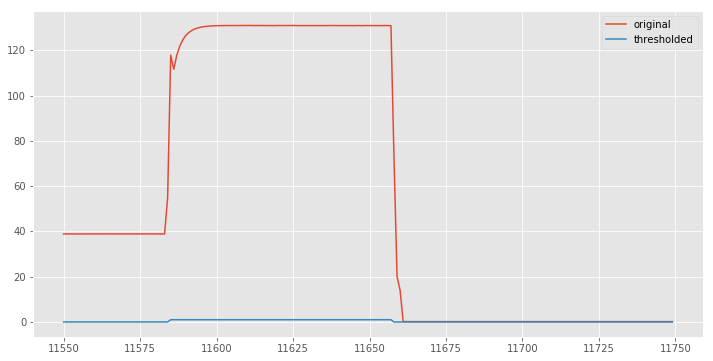

In [189]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
# startind = np.random.randint(low=0,high=50000-N)
N = 200
# startind = np.random.randint(len(brightnesses['left_ant']-N))
startind = 11550
inds = range(startind,startind+N)
# inds = range(1500,2500)
LA = brightnesses['left_ant'][inds]
LA_thresholded = LA>90
ax.plot(inds,LA)
ax.plot(inds,LA_thresholded*1)
ax.legend(['original','thresholded'])
plt.show()

In [190]:
thresholds = {}
thresholds['left_ant'] = 80
# doesn't work for some portions in the ~45000 range, nor 6000
thresholds['left_post']= 80
thresholds['right_ant'] = 80
thresholds['right_post'] = 80

In [636]:
data = {}
for cam in cams:
    data[cam]= (savgol_filter(brightnesses[cam],
                            window_length=5,polyorder=1) > thresholds[cam]).astype(np.float32)

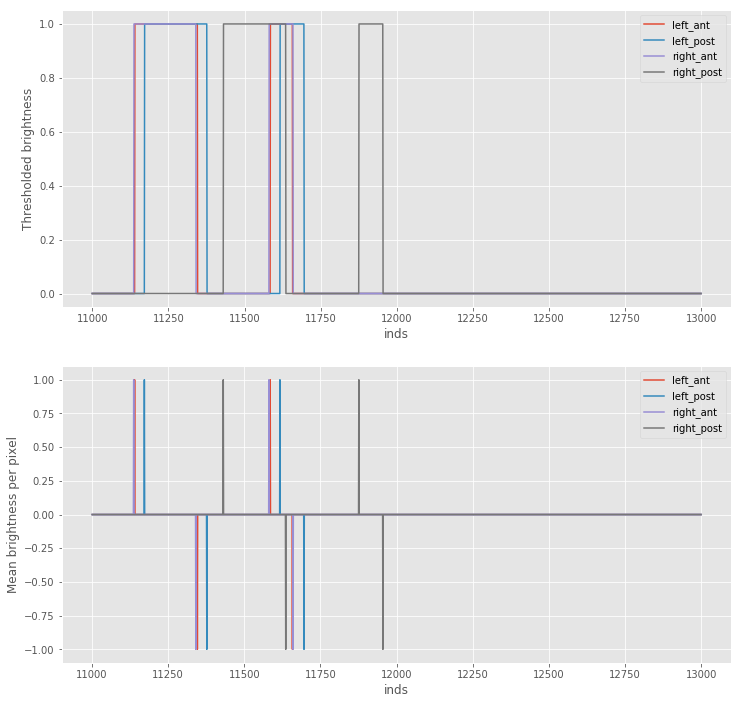

In [192]:
WINDOW_SIZE=3

fig, ax = plt.subplots(2,1, figsize=(12,12))
N = 2000
# startind = np.random.randint(low=0,high=55000-N)
startind=11000
inds = range(startind,startind+N)

for cam in cams:
    y = data[cam][inds]
    ax[0].plot(inds, y)
    ax[1].plot(inds[1:],np.diff(y))

ax[0].legend(['left_ant', 'left_post', 'right_ant', 'right_post'])
ax[0].set_ylabel('Thresholded brightness')
ax[0].set_xlabel('inds')

# y1 = np.diff(LA)
# ax[1].plot(inds[:-1], y1)
# y2 = np.diff(LP)
# ax[1].plot(inds[:-1], y2)
# y3 = np.diff(RA)
# ax[1].plot(inds[:-1], y3)
# y4 = np.diff(RP)
# ax[1].plot(inds[:-1], y4)
ax[1].legend(['left_ant', 'left_post', 'right_ant', 'right_post'])
ax[1].set_ylabel('Mean brightness per pixel')
ax[1].set_xlabel('inds')
# ax[1].set_ylim([-50,50])

plt.show()

In [120]:
import scipy.signal as signal

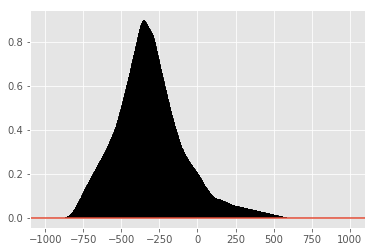

In [121]:
master = data['right_post']
inds = range(0,50000)
y1 = data['left_ant'][inds].astype(np.float64)
y2 = master[inds].astype(np.float64)
maxlags = 1000
fig, ax = plt.subplots(1,1)

lags, corr, _, _ = plt.xcorr(y1,y2, maxlags=maxlags)
# corr = signal.correlate(y1, y2, mode='full')


In [207]:
onsets = frames['right_post'][np.where(np.diff(data['right_post'])==1)[0]]
offsets = frames['right_post'][np.where(np.diff(data['right_post'])==-1)[0]]

cam = 'left_ant'
onsets2 = frames[cam][np.where(np.diff(data[cam])==1)[0]]
offsets2 = frames[cam][np.where(np.diff(data[cam])==-1)[0]]

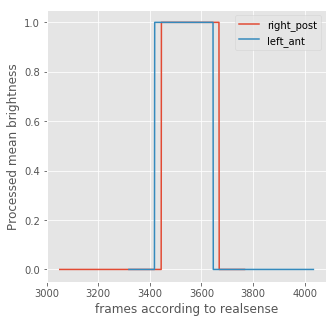

In [220]:
# verify that it works
ind = 0
buffer = 100

start = min(onsets[ind], onsets2[ind])-buffer
end = max(offsets[ind+1],offsets2[ind+1])+buffer
inds = range(start,end)

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(frames['right_post'][inds],data['right_post'][inds])
ax.plot(frames['left_ant'][inds],data['left_ant'][inds])
ax.legend(['right_post','left_ant'])
ax.set_xlabel('frames according to realsense')
ax.set_ylabel('Processed mean brightness')
plt.show()

In [637]:
cam = 'right_post'
onsets =frames[cam][np.where(np.diff(data[cam])==1)[0]]
offsets = frames[cam][np.where(np.diff(data[cam])==-1)[0]]

cam = 'left_ant'
onsets2 = frames[cam][np.where(np.diff(data[cam])==1)[0]]
offsets2 = frames[cam][np.where(np.diff(data[cam])==-1)[0]]

print('onsets: ', onsets.size, onsets2.size)
print('offsets:', offsets.size, offsets2.size)

onsets:  20 20
offsets: 21 21


In [631]:
onsets2.size

21

In [638]:
cam = 'right_post'
onsets =np.where(np.diff(data[cam])==1)[0]
offsets = np.where(np.diff(data[cam])==-1)[0]

cam = 'left_ant'
onsets2 = np.where(np.diff(data[cam])==1)[0]
offsets2 = np.where(np.diff(data[cam])==-1)[0]

In [639]:
print('Camera\'s framecount when brightness increase was observed\n')
print(' Master', ' Slave', ' Diff')
print(np.vstack((onsets, onsets2, onsets-onsets2)).T)

Camera's framecount when brightness increase was observed

 Master  Slave  Diff
[[ 3355  3062   293]
 [ 6081  5790   291]
 [ 8747  8457   290]
 [11430 11139   291]
 [11875 11584   291]
 [14120 13791   329]
 [16827 16473   354]
 [19533 19178   355]
 [22217 21863   354]
 [24914 24562   352]
 [27597 27243   354]
 [30251 29899   352]
 [32998 32647   351]
 [35732 35370   362]
 [38385 38023   362]
 [41097 40717   380]
 [43778 43405   373]
 [46425 46052   373]
 [49164 48792   372]
 [51868 51477   391]]


In [235]:
print(np.vstack((offsets, offsets2, offsets-offsets2)).T)

[[  964   951    13]
 [ 3668  3645    23]
 [ 6352  6329    23]
 [ 8985  8962    23]
 [11724 11701    23]
 [12043 12013    30]
 [14427 14353    74]
 [17108 17019    89]
 [19796 19707    89]
 [22549 22460    89]
 [25179 25090    89]
 [27935 27846    89]
 [30584 30495    89]
 [33540 33452    88]
 [36222 36122   100]
 [38950 38849   101]
 [41609 41499   110]
 [44336 44226   110]
 [47012 46902   110]
 [49711 49601   110]
 [52412 52282   130]]


In [640]:
cam = 'right_post'
onset_t = timestamps[cam][np.where(np.diff(data[cam])==1)[0]]
offset_t = timestamps[cam][np.where(np.diff(data[cam])==-1)[0]]

cam = 'left_post'
onset_t2 = timestamps[cam][np.where(np.diff(data[cam])==1)[0]]
offset_t2 = timestamps[cam][np.where(np.diff(data[cam])==-1)[0]]

In [641]:
print('Camera\'s timestamp when brightness increase was observed\n')
print('     Master              Slave           Diff(ms)')
for i in range(len(onset_t)):
    ms_difference = (onset_t[i]-onset_t2[i]).astype(np.float32)/1000
    ms_string = '{}'
    print('%s     %s     % 07.3f' %(str(onset_t[i])[11:],
                         str(onset_t2[i])[11:],
                         ms_difference))
    

Camera's timestamp when brightness increase was observed

     Master              Slave           Diff(ms)
15:04:59.307671     15:04:59.296646      11.025
15:05:29.653206     15:05:29.653206      00.000
15:05:59.330760     15:05:59.341881     -11.121
15:06:29.197710     15:06:29.197697      00.013
15:06:34.151310     15:06:34.151313     -00.003
15:06:59.142341     15:06:59.142341      00.000
15:07:29.276385     15:07:29.276384      00.001
15:07:59.399122     15:07:59.387976      11.146
15:08:29.277155     15:08:29.277160     -00.005
15:08:59.299824     15:08:59.310959     -11.135
15:09:29.166649     15:09:29.166650     -00.001
15:09:58.710700     15:09:58.721761     -11.061
15:10:29.290015     15:10:29.301080     -11.065
15:10:59.724371     15:10:59.846984     -122.613
15:11:29.257379     15:11:29.268520     -11.141
15:11:59.446999     15:11:59.369097      77.902
15:12:29.291552     15:12:29.291557     -00.005
15:12:58.757653     15:12:58.757651      00.002
15:13:29.247871     15:13:2

In [ ]:
onsets-(onsets[0]-onsets2[0])

In [ ]:
onsets2

In [ ]:
onsets2 - (onsets-307)[:len(onsets2)]

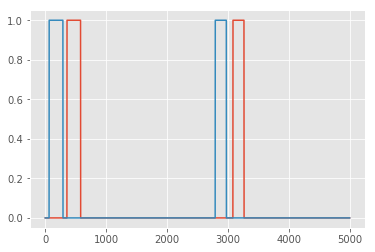

In [619]:
fig, ax = plt.subplots(1,1)
inds=range(3000,8000)
ax.plot(data['right_post'][inds])
ax.plot(data['left_ant'][inds])
plt.show()

In [ ]:
corr.shape

In [ ]:
bins = np.linspace(-1,1,100)

fig, ax = plt.subplots(2,2,figsize=(8,8))
array = np.diff(smooth(zscore(brightnesses[left_ant][inds]),window_size=WINDOW_SIZE))
histogram, bincenters = calculate_hist(array, bins)
ax[0,0].plot(bincenters, histogram)
ax[0,0].set_yscale('log')

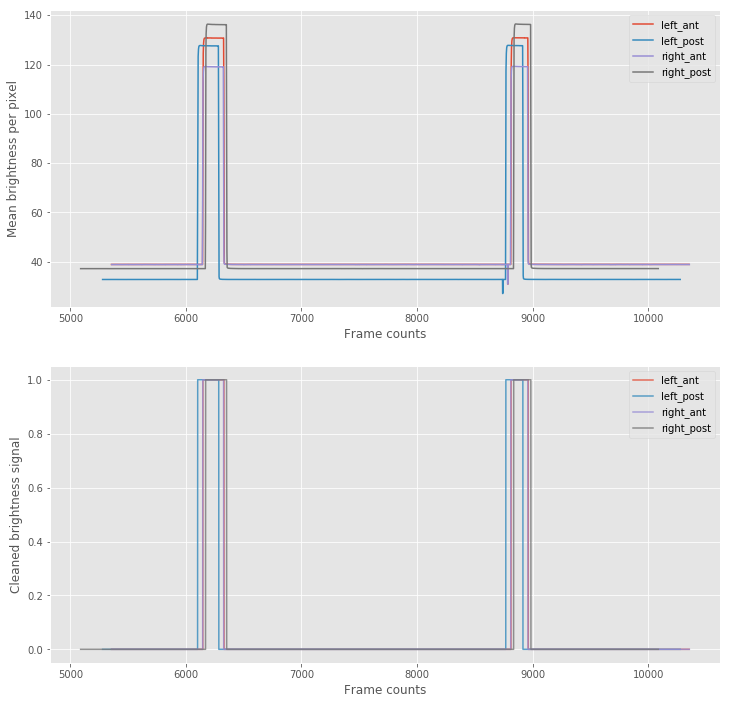

In [282]:
WINDOW_SIZE=3

fig, ax = plt.subplots(2,1, figsize=(12,12))
N = 5000
# startind = np.random.randint(len(brightnesses['left_ant']-N))
startind = 5000
inds = range(startind,startind+N)

for cam in cams:
    x = frames[cam][inds]
    array = savgol_filter(brightnesses[cam][inds],window_length=3,polyorder=1)
    # array = brightnesses[cam][inds]
    ax[0].plot(x,array)
    ax[1].plot(x, data[cam][inds],alpha=0.8)
    # ax[1].plot(inds[:-1],np.diff(array))

ax[0].legend(['left_ant', 'left_post', 'right_ant', 'right_post'])
ax[0].set_ylabel('Mean brightness per pixel')
ax[0].set_xlabel('Frame counts')

ax[1].legend(['left_ant', 'left_post', 'right_ant', 'right_post'])
ax[1].set_ylabel('Cleaned brightness signal')
ax[1].set_xlabel('Frame counts')
# ax[1].set_ylim([-50,50])

plt.show()

Use timestamps for alignment. Above experiments with light show that the cameras timestamps are only off by <100 ms throughout the ten minutes of imaging. 

* Make a big array, with N rows, and N-cams+1 columns
    * in the 0th row: `index of mastercam (so row number)`, `index of cam0 (NaN if DNE)`, `index of cam1`, `index of cam2`, `index of cam3`, `index of wavesurfer file corresponding to that frame`
* for each frame in the mastercam (always the biggest N)
    * find nearest frame in time in other 3 cams, within a given window (e.g. less than 1000 frames)
        * if the nearest entry is < 6ms or whatever, match, and delete that entry so it can't be matched
        * else, put a `NaN`


In [826]:
def align_cameras_on_timestamps(filelist,master='right_post', WINDOW_SIZE=500,
                               use_window=True):
    # WINDOW_SIZE=500
    max_distance = 6 # ms
    
    frames = {}
    timestamps = {}
    sestimes = {}
    # filelist.sort()
    for key, file in filelist.items():
        if not file.endswith('t.h5'):
            continue
        with h5py.File(file, 'r') as f:
            framecounts = f['framecount'][:]
            timestamp = timestamp_to_numpy(f['timestamp'][:])
            sestime = f['sestime'][:]
        # key = os.path.basename(file)[:-3]
        frames[key] = framecounts
        timestamps[key] = timestamp
        sestimes[key]  = sestime
    N = len(frames[master])
    camera_LUT = np.array((N,len(frames)), dtype=np.uint64)
    slaves = [i for i in list(frames.keys()) if i!=master]
    N = len(frames[master])
    camera_LUT = np.zeros((N,len(frames)), dtype=np.float64)
    
    for i in range(0,N):
        camera_LUT[i,0] = i
        t = timestamps[master][i]
        min_search = max(0,i-WINDOW_SIZE)
        
        for j, slave in enumerate(slaves):
            max_search = min(len(frames[slave]),i+WINDOW_SIZE)
            # happens when there are large differences in numbers of images between two files
            # this likely means the master has way more images than the slave
            if max_search==min_search:
                camera_LUT[i,j+1]=np.nan
                continue
            if use_window:
                snippet = np.abs((timestamps[slave][min_search:max_search]-t).astype(np.float32)/1000)
                
            else:
                snippet = np.abs((timestamps[slave]-t).astype(np.float32)/1000)
            mint, argmin = snippet.min(), np.argmin(snippet)
            
            if mint < max_distance:
                val = argmin + min_search
            else:
                val = np.nan
            
            camera_LUT[i,j+1] = val
    
    # data = np.hstack((camera_LUT, timestamps[master]))
    df = pd.DataFrame(camera_LUT, columns=[master]+slaves)
    df['timestamps'] = timestamps[master]
    
    return(df)

In [808]:
filelist = {os.path.basename(i)[:-3]:i for i in files if i.endswith('t.h5')}

In [809]:
filelist

{'left_ant': '/media/jim/FASTER/realsense/lighttest_sparserv3_190420_150419/left_ant.h5',
 'left_post': '/media/jim/FASTER/realsense/lighttest_sparserv3_190420_150419/left_post.h5',
 'right_ant': '/media/jim/FASTER/realsense/lighttest_sparserv3_190420_150419/right_ant.h5',
 'right_post': '/media/jim/FASTER/realsense/lighttest_sparserv3_190420_150419/right_post.h5'}

In [810]:
LUT = align_cameras_on_timestamps(filelist)

In [434]:
timestamps['left_post'][140]

numpy.datetime64('2019-03-20T15:04:26.401933')

In [435]:
timestamps['right_ant'][104]

numpy.datetime64('2019-03-20T15:04:26.401933')

In [436]:
timestamps['right_post'][399]

numpy.datetime64('2019-03-20T15:04:26.401940')

In [443]:
camera_LUT[295,:]

array([295.,  13.,  36.,   0.])

# Use the camera LUT and brightnesses to verify alignment

In [811]:
increase = np.where(np.diff(data[master])>0.5)[0]

In [518]:
camera_LUT[index-100:index+10,:]

array([[19433., 19080., 19165., 19129.],
       [19434., 19081., 19166., 19130.],
       [19435., 19082., 19167., 19131.],
       [19436., 19083., 19168., 19132.],
       [19437., 19084., 19169., 19133.],
       [19438., 19085., 19170., 19134.],
       [19439., 19086., 19171., 19135.],
       [19440., 19087., 19172., 19136.],
       [19441., 19088., 19173., 19137.],
       [19442., 19089., 19174., 19138.],
       [19443., 19090., 19175., 19139.],
       [19444., 19091., 19176., 19140.],
       [19445., 19092., 19177., 19141.],
       [19446., 19093., 19178., 19142.],
       [19447., 19094., 19179., 19143.],
       [19448., 19095., 19180., 19144.],
       [19449., 19096., 19181., 19145.],
       [19450., 19097., 19182., 19146.],
       [19451., 19098., 19183., 19147.],
       [19452., 19099., 19184., 19148.],
       [19453., 19100., 19185., 19149.],
       [19454., 19101., 19186., 19150.],
       [19455., 19102., 19187., 19151.],
       [19456., 19103., 19188., 19152.],
       [19457., 

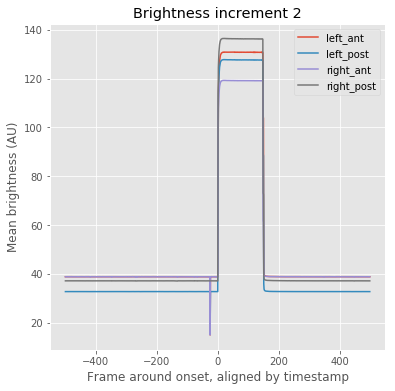

In [818]:
i = np.random.randint(low=0,high=len(increase)-1)
index = int(increase[i])
LA_i = int(camera_LUT[index,1])
LP_i = int(camera_LUT[index,2])
RA_i = int(camera_LUT[index,3])

fig, ax = plt.subplots(1,1,figsize=(6,6))
x = range(-window,window)
ax.plot(x,brightnesses['left_ant'][LA_i-window:LA_i+window])
ax.plot(x, brightnesses['left_post'][LP_i-window:LP_i+window])
ax.plot(x, brightnesses['right_ant'][RA_i-window:RA_i+window])
ax.plot(x,brightnesses[master][index-window:index+window])
ax.legend(cams)
ax.set_title('Brightness increment %d' %(i))
ax.set_ylabel('Mean brightness (AU)')
ax.set_xlabel('Frame around onset, aligned by timestamp')
plt.show()

In [508]:
index

14120

In [447]:

onsets

array([  685517,   686771,   687884, ..., 59856796, 59857909, 59858308])

In [523]:
np.sum(np.isnan(camera_LUT[295:,:]))

230

In [413]:
slave = 'left_ant'
snippet = np.abs((timestamps[slave][min_search:max_search]-t).astype(np.float32)/1000)

In [414]:
mint, argmin = snippet.min(), np.argmin(snippet)

In [427]:
mint, argmin

(0.001, 218)

In [417]:
i-500+argmin

317

In [422]:
min_search+argmin

317

In [419]:
timestamps[slave][317]

numpy.datetime64('2019-03-20T15:04:28.628224')

In [401]:
(timestamps['left_ant'][min_search:max_search]-t).astype(np.float64)/1000

array([-2426.75 , -2415.588, -2404.471, -2393.324, -2382.179, -2371.007,
       -2359.947, -2348.836, -2337.67 , -2326.574, -2315.437, -2304.285,
       -2293.156, -2282.033, -2270.867, -2259.717, -2248.603, -2237.519,
       -2226.292, -2215.227, -2204.099, -2192.952, -2181.84 , -2170.722,
       -2159.578, -2148.417, -2137.286, -2126.177, -2115.046, -2103.92 ,
       -2092.758, -2081.664, -2070.524, -2059.385, -2048.268, -2037.115,
       -2025.98 , -2014.878, -2003.727, -1992.576, -1981.455, -1970.354,
       -1959.186, -1948.006, -1936.939, -1925.76 , -1914.589, -1903.531,
       -1892.382, -1881.28 , -1870.163, -1858.999, -1847.891, -1836.761,
       -1825.649, -1814.511, -1803.317, -1792.195, -1781.084, -1769.949,
       -1758.831, -1747.71 , -1736.535, -1725.444, -1714.236, -1703.125,
       -1691.969, -1680.827, -1669.708, -1658.593, -1647.513, -1636.383,
       -1625.237, -1614.044, -1602.999, -1591.827, -1580.689, -1569.581,
       -1558.408, -1547.319, -1536.187, -1525.049, 

In [362]:
blah = timestamps[master]

In [367]:
np.where((np.diff(blah)/1000).astype(np.float32)>12)

(array([8737]),)

In [364]:
blah[0]

numpy.datetime64('2019-03-20T15:04:21.960216')

# Assuming the timestamps are a worthy synchronization signal

In [302]:
syncfile = [i for i in files if i.endswith('_0001.h5')][0]

In [316]:
with h5py.File(syncfile, 'r') as f:
    V = f['sweep_0001/digitalScans'][:]

In [558]:
onsets = np.where(np.diff(V.astype(np.int16))>0.5)[1]

In [561]:
print(len(onsets), frames[master].size)

53158 53048


In [563]:
frames[master].max()

53136

In [346]:
frames['right_post'][0]

89

In [326]:
frames['right_post'][-1]

53136

In [331]:
np.diff(frames['right_ant']>1).sum()

0

In [319]:
np.sum(np.diff(V.astype(np.int16))>0.5)

53158

# Check image quality. Show example images. Make example movies

In [757]:
def get_frames_by_index(camfiles, LUT, index, blank_frame=False, shape=(270,480)):
    lefts = []
    rights = []
    row = LUT.iloc[index,:]
    t = np.datetime64(row['timestamps'])
    for camname, file in camfiles.items():
        camind = row[camname]
        if not np.isnan(camind):
            camind = int(camind)
            with h5py.File(file, 'r') as f:
                left = cv2.imdecode(f['left'][camind],0)
                right = cv2.imdecode(f['right'][camind],0)
        else:
            if blank_frame:
                if len(lefts)> 0:
                    left = np.zeros_like(lefts[0])
                    right = np.zeros_like(rights[0])
                else:
                    left = np.zeros(shape, dtype=np.uint8)
                    right = np.zeros(shape, dtype=np.uint8)
            else:
                left, right = None, None
        lefts.append(left)
        rights.append(right)
            
    return(lefts, rights)

In [913]:
datedir = r'/media/jim/FASTER/realsense/190322'
indatedir = os.listdir(datedir)
indatedir.sort(key=str.casefold)

datafile = indatedir[0]
print(datafile)
datadir = os.path.join(datedir, datafile)

JB040_193822_113835


In [914]:
camfiles

{'left_ant': '/media/jim/FASTER/realsense/190321/JB043_194421_154409/left_ant.h5',
 'left_post': '/media/jim/FASTER/realsense/190321/JB043_194421_154409/left_post.h5',
 'right_ant': '/media/jim/FASTER/realsense/190321/JB043_194421_154409/right_ant.h5',
 'right_post': '/media/jim/FASTER/realsense/190321/JB043_194421_154409/right_post.h5'}

In [915]:
camfiles = os.listdir(datadir)
camfiles.sort()
camfiles = {os.path.basename(i)[:-3]: os.path.join(datadir,i) for i in camfiles if i.endswith('t.h5')}

LUT = align_cameras_on_timestamps(camfiles)

In [916]:
index = np.random.randint(low=0, high=len(LUT))
lefts, rights = get_frames_by_index(camfiles, LUT, index)

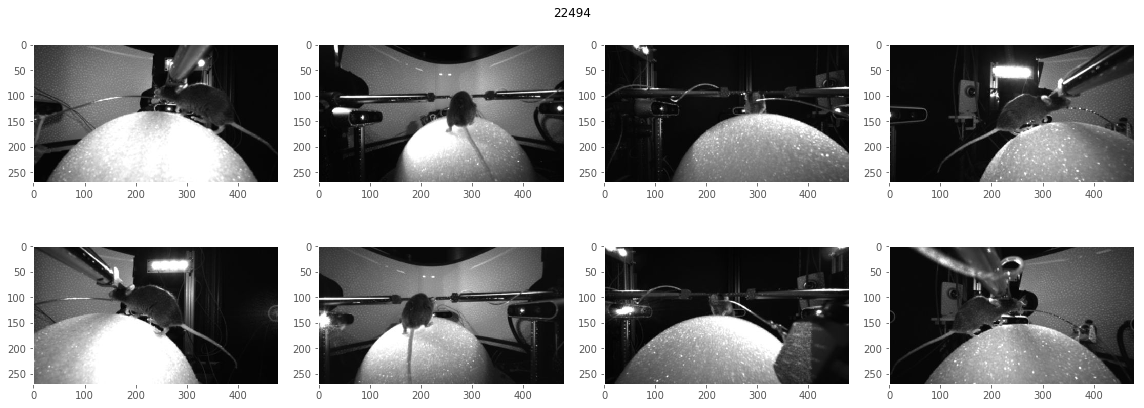

In [917]:
fig, ax = plt.subplots(2,4,figsize=(16,6))
for i in range(4):
    left = lefts[i]
    right = rights[i]
    if left is not None:
        ax[0,i].imshow(left, 'gray')
        ax[1,i].imshow(right,'gray')
    else:
        ax[0,i].remove()
        ax[1,i].remove()
    ax[0,i].grid(False)
    ax[1,i].grid(False)
fig.suptitle('%d'%index)
plt.tight_layout()
plt.show()
    

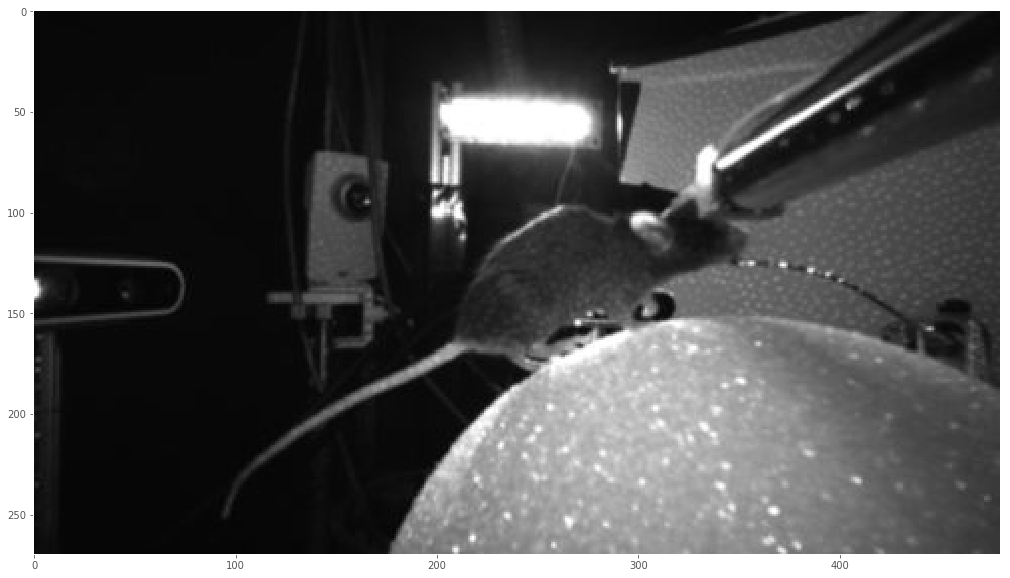

In [926]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
ax.imshow(lefts[3],'gray', interpolation='nearest')
ax.grid(False)
plt.show()

In [945]:
N=1800
index = np.random.randint(low=0, high=len(LUT)-N)
# index = 172014
# index = 547
indices = range(index, index+N)

In [944]:
preview = True
save = False
mouse = 'JB040'

width = 480
height = 270
fps = 30

In [946]:
N_cams = 4
framesize = (width*4, height*2)

startind = indices[0]
endind = indices[-1]
if preview:
#     cv2.namedWindow('Realsense', cv2.WINDOW_AUTOSIZE)
#     cv2.namedWindow('Flea', cv2.WINDOW_AUTOSIZE)
    cv2.namedWindow('Joined', cv2.WINDOW_AUTOSIZE)
    waittime = int(1000/fps)
if save:
    outdir = os.path.join(datadir, 'examples')
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    filename = '%s_%07d_%07d.avi' %(mouse, startind, endind)
    writer = cv2.VideoWriter(os.path.join(outdir, filename),fourcc, fps, framesize)
try:
    for i in range(startind,endind):
        t0 = time.perf_counter()
        
        lefts, rights = get_frames_by_index(camfiles, LUT, i, blank_frame=True,
                                           shape=(height,width))
        top = np.hstack(lefts)
        bottom = np.hstack(rights)
        out = np.vstack((top,bottom))

        #         r = np.hstack((r_l, r_r))
        #         f = np.hstack((f_l, f_r))

        #         rheight, rwidth = r.shape
        #         fheight, fwidth = f.shape
        #         out_width = int(fwidth)
        #         out_height = int(fwidth/rwidth*rheight)
        #         out = np.vstack((cv2.resize(r,(out_width,out_height)),
        #                         f))
        out = cv2.cvtColor(out, cv2.COLOR_GRAY2RGB)
        text = '%s:%07d' %(mouse, i)
        cv2.putText(out, text, (50,out.shape[0]-50),
                   fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,
                   color=(0,0,255),thickness=1,lineType=cv2.LINE_AA)
        if save:
            writer.write(out)

        if preview:
            # cv2.imshow('Realsense', r)
            # cv2.imshow('Flea',f)
            cv2.imshow('Joined', out)
            elapsed = int((time.perf_counter() - t0)*1000)

            key = cv2.waitKey(max([1,elapsed]))
            if key==27:
                print('User stopped')
                break
                # raise KeyboardInterrupt
except BaseException as e:
    print(e.message)
finally:
    if preview:
        cv2.destroyAllWindows()
    if save:
        writer.release()